In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [9]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')

if src_path not in sys.path:
    sys.path.append(src_path)

In [10]:
from utils import load_data, transform_data
from data_vis import plot_candlestick, plot_time_series, plot_normalized_pair, plot_series
from comp_utils import find_best_pair_for_ticker, get_pairs, get_residuals

In [11]:
btc_data = transform_data(load_data("BTCUSDT"))
eth_data = transform_data(load_data("ETHUSDT"))
ada_data = transform_data(load_data("ADAUSDT"))
bnb_data = transform_data(load_data("BNBUSDT"))
doge_data = transform_data(load_data("DOGEUSDT"))
link_data = transform_data(load_data("LINKUSDT"))
sol_data = transform_data(load_data("SOLUSDT"))
wbtc_data = transform_data(load_data("WBTC"))
xrp_data = transform_data(load_data("XRPUSDT"))
usdc_data = transform_data(load_data("USDCUSDT"))
avax_data = transform_data(load_data("AVAXUSDT"))
bch_data = transform_data(load_data("BCHUSDT"))
dai_data = transform_data(load_data("DAIUSDT"))
ltc_data = transform_data(load_data("LTCUSDT"))
xlm_data = transform_data(load_data("XLMUSDT"))

In [12]:
#Candlestick charts for visualization
plot_candlestick(btc_data, "BTCUSDT", start_idx=0, end_idx=200)

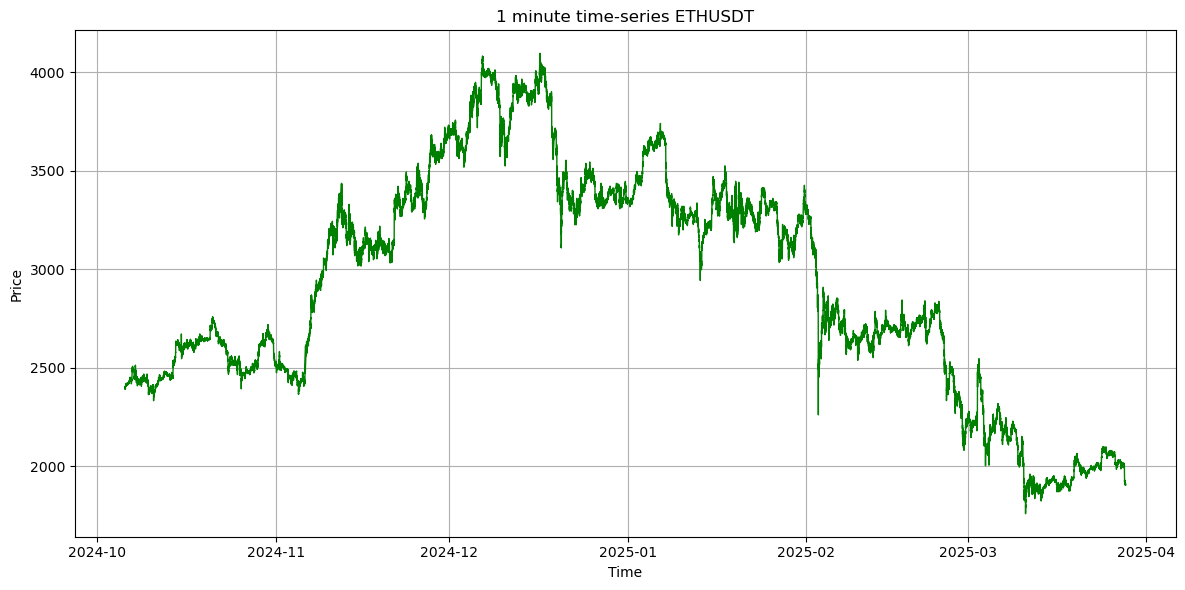

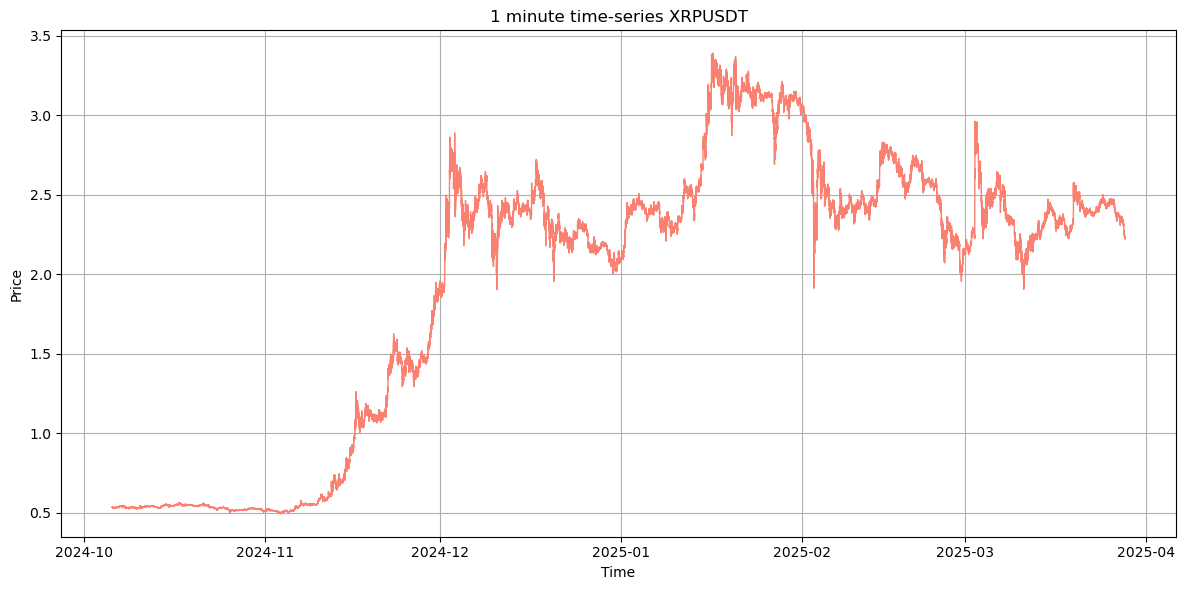

In [13]:
#visualize the mid-price time-series 
plot_time_series(eth_data, ticker="ETHUSDT", color='green', start_idx=400000, end_idx=650000)
plot_time_series(xrp_data, ticker="XRPUSDT", color='salmon', start_idx=400000, end_idx=650000)

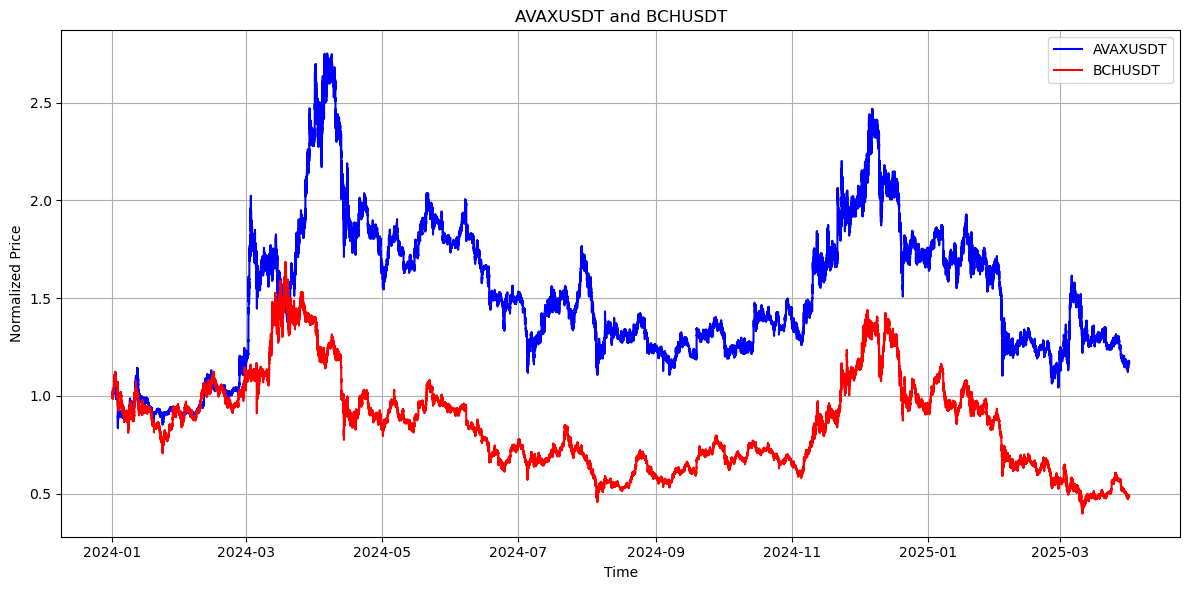

In [14]:
# visualize the normalized time-series of two assets on a normalized y-axis 
plot_normalized_pair(bch_data, avax_data, title="AVAXUSDT and BCHUSDT", label1="AVAXUSDT", label2="BCHUSDT", color2 = 'red')

In [15]:
data_dict = {
    "BTCUSDT": btc_data, 
    "ETHUSDT": eth_data, 
    "ADAUSDT": ada_data, 
    "BNBUSDT": bnb_data, 
    "DOGEUSDT": doge_data, 
    "LINKUSDT": link_data,
    "SOLUSDT": sol_data, 
    #"WBTC": wbtc_data, 
    "XRPUSDT": xrp_data, 
    "BCHUSDT": bch_data,
    #"DAIUSDT": dai_data,
    "LTCUSDT": ltc_data,
    "XLMUSDT": xlm_data,
    "AVAXUSDT": avax_data,
}

## PCA Stat Arb Implementation
#### 1. Computing PCA factors

In [16]:
from comp_utils import get_Y, fit_ou_params

In [17]:
# our N x M standardized returns matrix 
Y = get_Y(data_dict)
Y

array([[-1.29616895, -1.67408114, -0.05558414, ...,  0.02176366,
         0.01948536,  0.0194953 ],
       [ 1.97244513, -0.30646456, -0.1723905 , ...,  2.16723645,
        -0.54446303, -0.00525117],
       [-0.05764572, -1.17301734, -0.03482777, ...,  0.23661429,
         0.20914344,  0.20914344],
       ...,
       [-0.06594934, -0.06594934, -0.06594934, ...,  0.03852239,
         0.03595025, -0.72019573],
       [ 0.04054583,  0.04054583,  0.04054583, ...,  0.18296666,
        -2.31390035,  0.07452145],
       [-0.21467814, -0.21273149, -0.07368981, ...,  0.03114243,
         0.03114243,  0.03114243]])

In [18]:
# constructing the N x N correlation matrix 
M = Y.shape[1]
P = (1 / (M - 1)) * (Y @ Y.T)
P

array([[1.00701516, 0.28383315, 0.19537395, 0.14217804, 0.16452746,
        0.19314676, 0.18799641, 0.16557642, 0.06806103, 0.15456498,
        0.10462938, 0.18542363],
       [0.28383315, 1.01436651, 0.22088564, 0.15473222, 0.17757829,
        0.22774751, 0.19543047, 0.18874304, 0.07853704, 0.17396749,
        0.12442902, 0.21007312],
       [0.19537395, 0.22088564, 0.99822913, 0.12733972, 0.14017517,
        0.21194143, 0.14637634, 0.19512512, 0.07382919, 0.16755011,
        0.13773319, 0.19838639],
       [0.14217804, 0.15473222, 0.12733972, 1.00513526, 0.10789219,
        0.12548128, 0.10510056, 0.11083937, 0.05418536, 0.10708842,
        0.07232721, 0.12055667],
       [0.16452746, 0.17757829, 0.14017517, 0.10789219, 1.00140245,
        0.13638189, 0.23202835, 0.12067014, 0.06112734, 0.11576248,
        0.06836534, 0.13014333],
       [0.19314676, 0.22774751, 0.21194143, 0.12548128, 0.13638189,
        1.00780798, 0.14047039, 0.17392497, 0.07535716, 0.16765571,
        0.12794602,

In [19]:
# computing the principal components 
eigenvalues, eigenvectors = np.linalg.eigh(P)
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

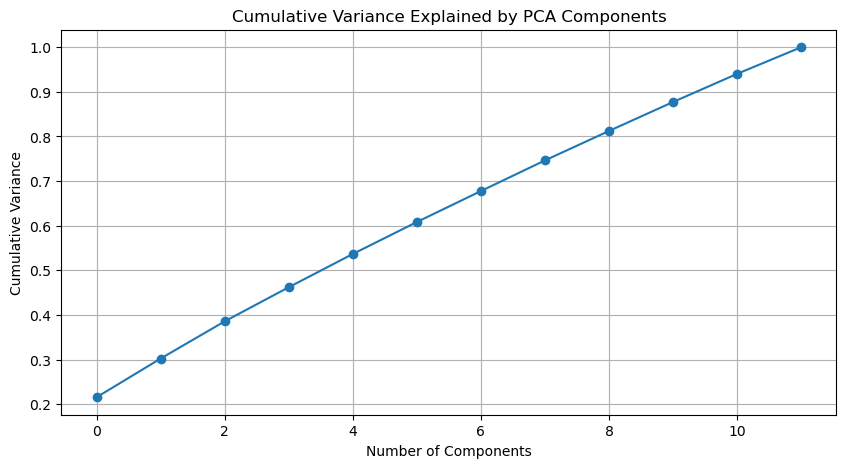

In [20]:
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o')
plt.title("Cumulative Variance Explained by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.grid(True)
plt.show()


#### 2. Constructing Eigenportfolios

In [21]:
k = 7 # number of eigenportfolios, explains roughly 0.1k variance

In [22]:
# constructing the Q_matrix, each column is an eigenportfolio
volatilities = np.std(Y, axis=1)
top_k_eigenvectors = eigenvectors[:, :k]
Q_matrix = top_k_eigenvectors / volatilities[:, np.newaxis]

In [23]:
asset_names = list(data_dict.keys())
print("="*60)
print("Q_matrix shape:", Q_matrix.shape)
print("Eigenportfolio 3 weights:")
for name, weight in zip(asset_names, Q_matrix[:, 2]):
    print(f"{name}: {weight:.4f}")

Q_matrix shape: (12, 7)
Eigenportfolio 3 weights:
BTCUSDT: 0.0363
ETHUSDT: 0.0474
ADAUSDT: 0.1105
BNBUSDT: -0.0181
DOGEUSDT: -0.1632
LINKUSDT: 0.0944
SOLUSDT: -0.1275
XRPUSDT: 0.1381
BCHUSDT: -0.9073
LTCUSDT: 0.0338
XLMUSDT: 0.2163
AVAXUSDT: 0.0658


In [24]:
# each row of F matrix is a factor return time-series; there are k rows
F_matrix = Q_matrix.T @ Y

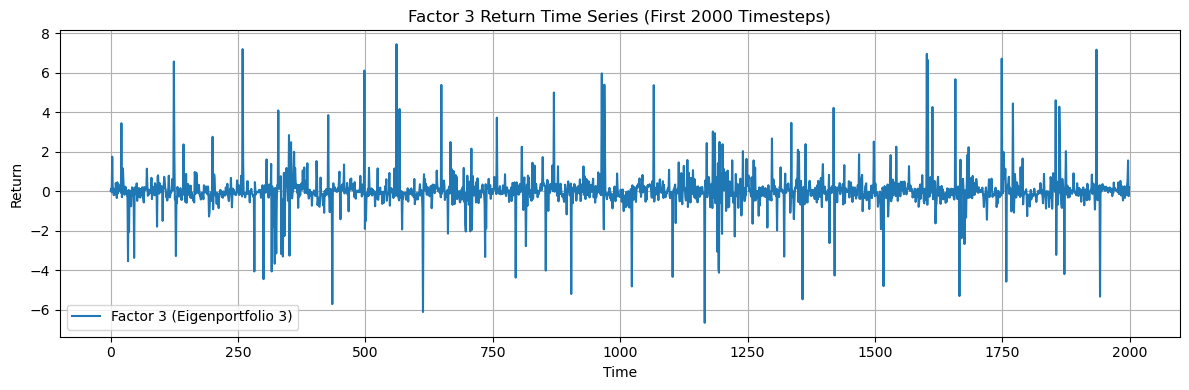

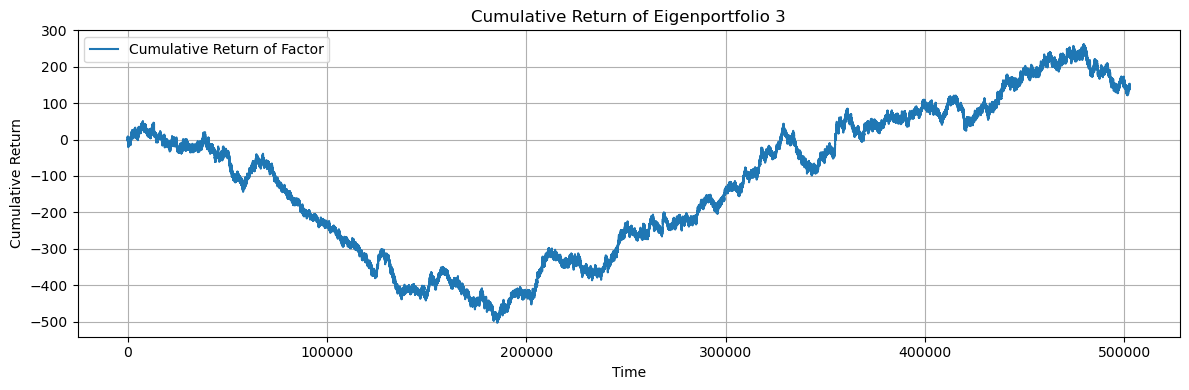

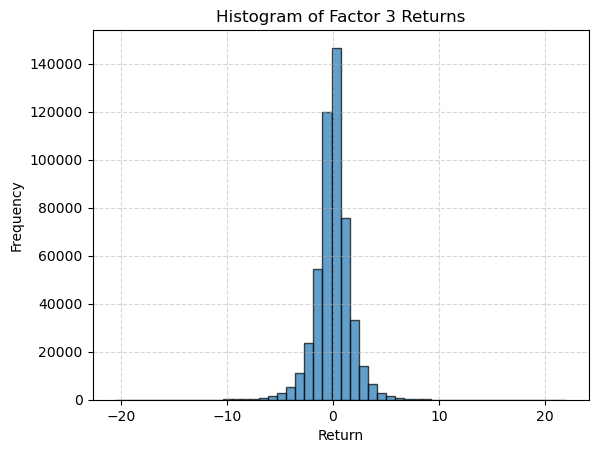

In [25]:
# visualizing factor returns 

plt.figure(figsize=(12, 4))
plt.plot(F_matrix[2][:2000], label='Factor 3 (Eigenportfolio 3)')
plt.title("Factor 3 Return Time Series (First 2000 Timesteps)")
plt.xlabel("Time")
plt.ylabel("Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

cumulative_factor = np.cumsum(F_matrix[2])

plt.figure(figsize=(12, 4))
plt.plot(cumulative_factor, label='Cumulative Return of Factor')
plt.title("Cumulative Return of Eigenportfolio 3")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.hist(F_matrix[0], bins=50, edgecolor='black', alpha=0.7)
plt.title("Histogram of Factor 3 Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [26]:
# solve linear-regression least squares to regress returns 
FF_inv = np.linalg.inv(F_matrix @ F_matrix.T)
beta_matrix = (Y @ F_matrix.T) @ FF_inv
Y_hat = beta_matrix @ F_matrix
residuals = Y - Y_hat

In [27]:
X_matrix = np.cumsum(residuals, axis=1)

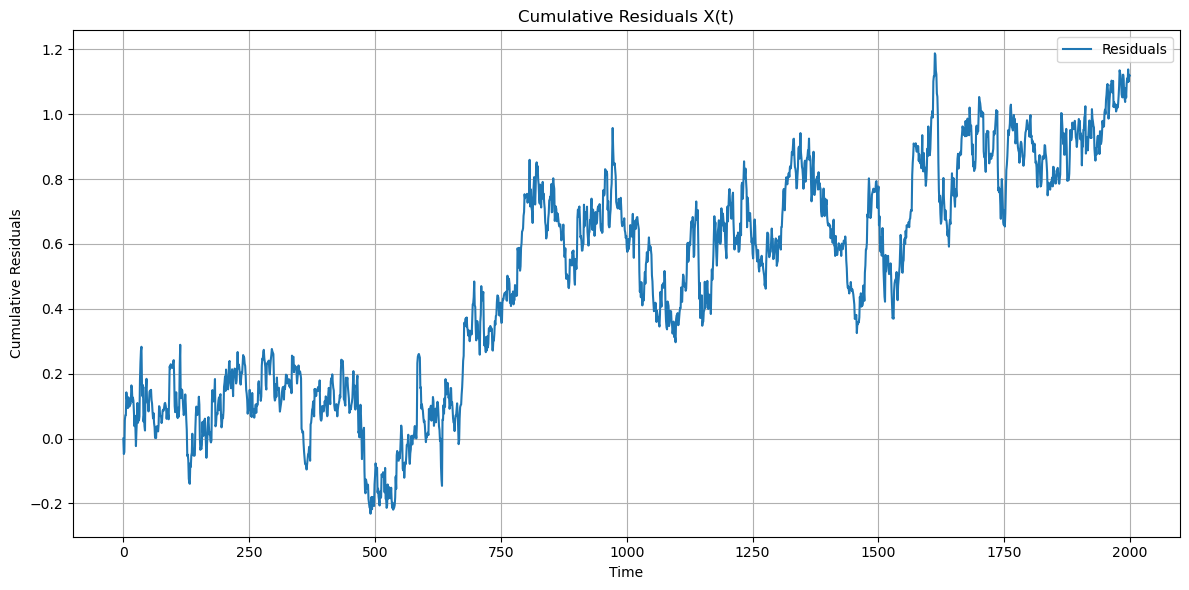

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(X_matrix[8][:2000], label='Residuals')
plt.title("Cumulative Residuals X(t)")
plt.xlabel("Time")
plt.ylabel("Cumulative Residuals")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
s_scores = np.zeros_like(X_matrix)

ou_params = []

for i in range(X_matrix.shape[0]):
    X_series = X_matrix[i]
    a, b, kappa, m, sigma, sigma_eq = fit_ou_params(X_series)
    s_scores[i] = (X_series - m) / sigma_eq
    ou_params.append((a, b, kappa, m, sigma, sigma_eq))

In [30]:
from backtester import generate_signals

In [31]:
# N x M positions matrix encoding our position by asset at time t 
positions = generate_signals(s_scores, s_entry=1.25, s_exit=0.5)

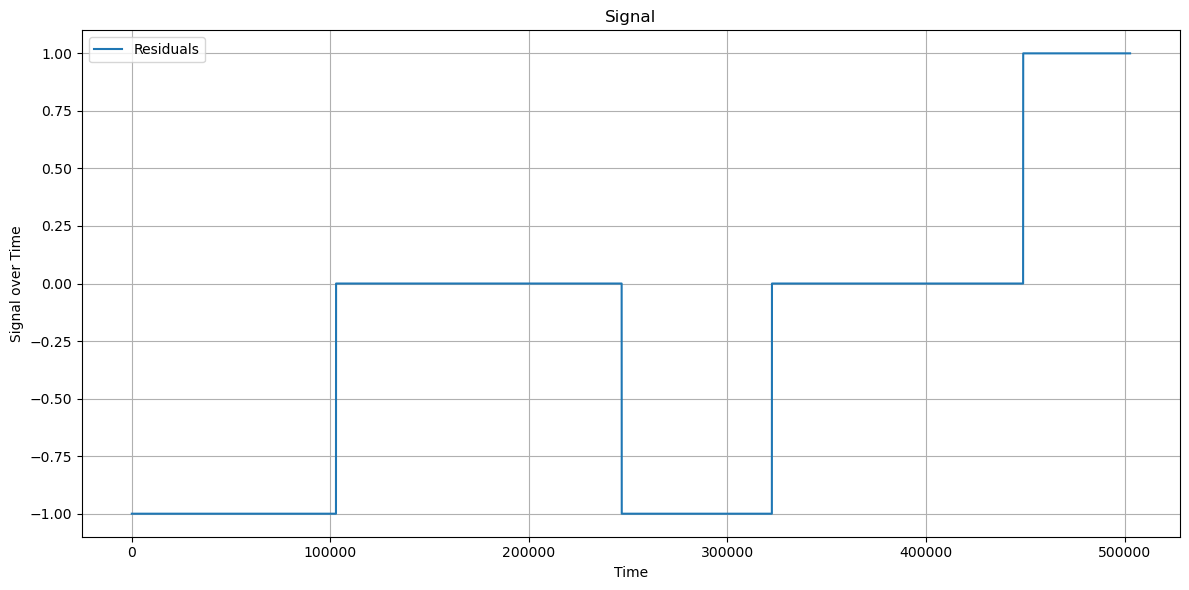

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(positions[9], label='Residuals')
plt.title("Signal")
plt.xlabel("Time")
plt.ylabel("Signal over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Running the backtesting simulator (using rolling windows to avoid look-ahead bias)

In [33]:
from simulator import Simulator

In [127]:
start = 0
end = 2880
a = 8

In [128]:
sim = Simulator(
    data_dict=data_dict,
    ret_window=2440,
    pca_window=2440,
    ou_window=2440,
    k=7,
    s_entry=2,
    s_exit=0.1,
    pca_update_interval=20,
    start_index= start + a*2880,
    end_index= end + a*2800    
)


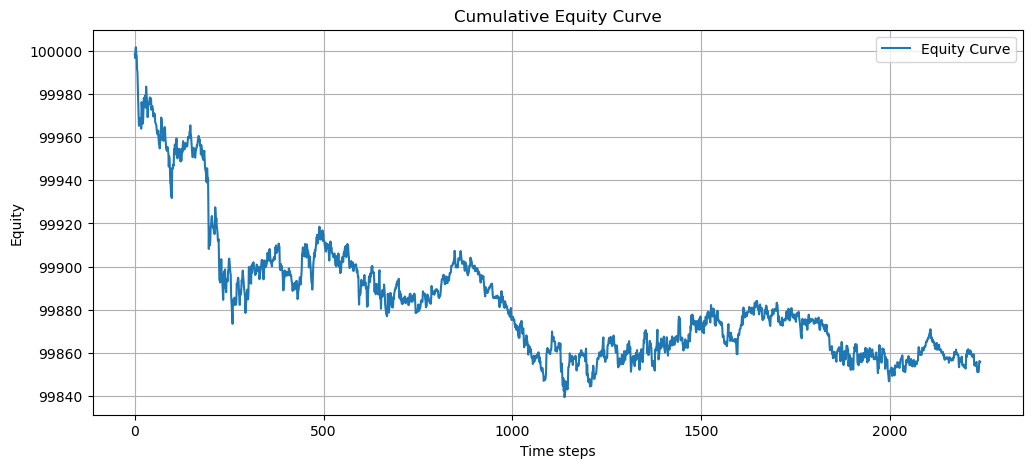

In [129]:
sim.run_simulation()
sim.plot_equity_curve()

##### 1-min candles might be too noisy and influenced by microstructure noise to extract any meaningful value. The paper is implemented on daily equities data. Let us try resampling our data into longer frame candles for a more 'mid-frequency' strategy and see if that yields any better results. 

In [131]:
resampled_data_dict = {}

for name, df in data_dict.items():
    df = df.copy()
    
    if not isinstance(df.index, pd.DatetimeIndex):
        if 'open_time' in df.columns:
            df['open_time'] = pd.to_datetime(df['open_time'])
            df.set_index('open_time', inplace=True)
        else:
            raise ValueError(f"DataFrame for {name} does not have a datetime index or 'open_time' column.")

    # Resample to 5-minute candles using last price
    df_resampled = df['mid'].resample('5min').last().dropna().to_frame(name='mid')
    resampled_data_dict[name] = df_resampled


In [ ]:
sim = Simulator(
    data_dict=resampled_data_dict,
    ret_window=288, 
    pca_window=288,
    ou_window=288,
    k=5,
    s_entry=2.0,
    s_exit=0.75,
    start_index=300,
    end_index=1200
)
sim.run_simulation()
sim.plot_equity_curve()